In [1]:
!pip install segmentation-models-pytorch --quiet

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.9 MB/s eta 0:00:00


In [2]:
from google.colab import files

# Upload images (documents)
print("Upload your image files (like doc1.png)...")
uploaded_images = files.upload()

# Upload masks (segmentations)
print("Upload your mask files (like doc1_mask.png)...")
uploaded_masks = files.upload()

Upload your image files (like doc1.png)...


Saving Engineer-Resume.png to Engineer-Resume.png
Upload your mask files (like doc1_mask.png)...


Saving corresponding_mask.png to corresponding_mask.png


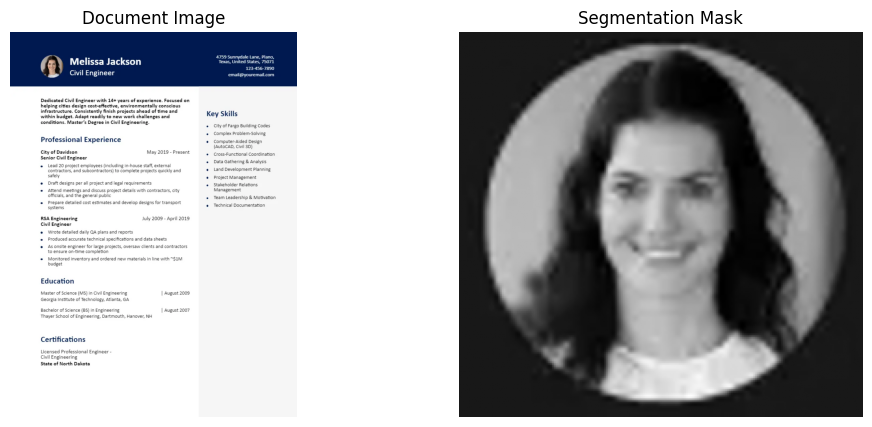

In [3]:
# Load the uploaded document image
doc_img = Image.open("Engineer-Resume.png").convert('RGB')
# Load the corresponding mask
mask_img = Image.open("corresponding_mask.png").convert('L')  # 'L' for grayscale

# Display both side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(doc_img)
plt.title("Document Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_img, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()

In [4]:
# Resize both images to the same size if needed
size = (256, 256)

doc_resized = doc_img.resize(size)
mask_resized = mask_img.resize(size)

# Convert to NumPy arrays
doc_array = np.array(doc_resized) / 255.0  # Normalize to [0, 1]
mask_array = np.array(mask_resized) / 255.0  # Normalize to [0, 1]

# Optional: Convert mask to binary
mask_array = (mask_array > 0.5).astype(np.uint8)

In [5]:
# Add batch and channel dimensions
doc_input = np.expand_dims(doc_array, axis=0)  # Shape: (1, 256, 256, 3)
mask_input = np.expand_dims(mask_array, axis=(0, -1))  # Shape: (1, 256, 256, 1)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D()(c3)
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    return models.Model(inputs, outputs)

model = build_unet((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,689 (182.38 KB)

 Trainable params: 46,689 (182.38 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(doc_input, mask_input, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6549 - loss: 0.6703
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6552 - loss: 0.6885
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - accuracy: 0.6552 - loss: 0.6654
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - accuracy: 0.6552 - loss: 0.6640
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - accuracy: 0.6552 - loss: 0.6623
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6552 - loss: 0.6573
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6552 - loss: 0.6571
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.6552 - loss: 0.6505
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6552 - loss: 0.6439
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step - accuracy: 0.6552 - loss: 0.6392


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


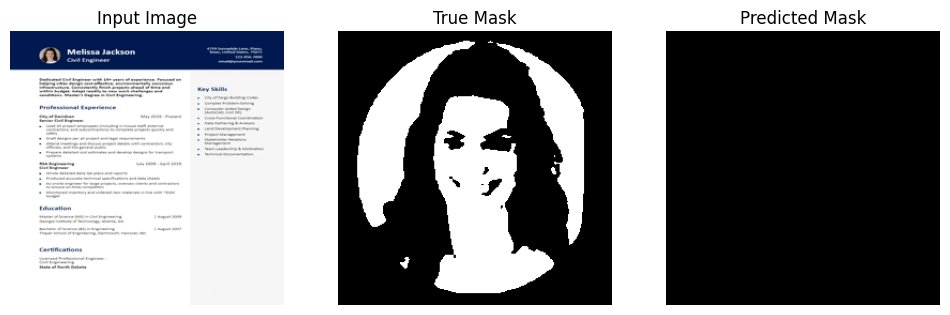

In [8]:
pred = model.predict(doc_input)[0, :, :, 0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(doc_array)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_array, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()